In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

%matplotlib inline

In [59]:
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('Set2')

Importing data

In [60]:
# artist -> instagram
artist_insta = pd.read_csv('./output/name_insta_data.txt', header=0,
                        index_col=0)

# instagram -> n_followers

follower_count = pd.read_pickle('./output/follower_count.pkl')

Let's organize the data a little bit. 

In [61]:
data = pd.DataFrame(columns=['Instagram','Followers', 'Artist'])

for i, cell in enumerate(artist_insta.loc[:, "Instagram"]):
    for insta in literal_eval(cell):
        data = data.append(dict(Artist = artist_insta.loc[i,'Name'], 
                                Instagram = insta,
                               Followers = follower_count.loc[insta,0]),
                          ignore_index=True)

In [62]:
data.head()

,Instagram,Followers,Artist
0,heartless_trash252,1210.0,NaN
1,eternaltattoone,1243.0,Aaron Beaudette
2,aaronbeaudette,1513.0,Aaron Beaudette
3,ace_of_art,25543.0,Aaron Rhaburn
4,aaronistattoo,33630.0,Aaron Is


Filter out instagrams which we weren't able to get number of followers
and remove duplicates.

In [63]:
data = data.loc[~data['Followers'].isnull(),:]
data.drop_duplicates(inplace=True)

An import thing to keep in mind is that a lot fo the artists have two or more instagram accounts associated with them. That is because in their villain-arts profile page they list their personal account and also the account of their studio.

Let's look at how many of the instagram accounts are associated with more than one artist. These should not be personal accounts.

In [64]:
data['Instagram'].describe()

count                         277
unique                        259
top       blacksheeptattoostudios
freq                            3
Name: Instagram, dtype: object

We see that 259 out of the 278 entries are unique.
Let's look only at instagram by followers. To do so we'll create a new DataFrame
by dropping duplicates.

In [65]:
df_count = data.drop_duplicates(subset=['Instagram']).loc[:,['Instagram', 'Followers']]
df_count.set_index('Instagram', inplace=True)

Let's take a first look at the follower distribution

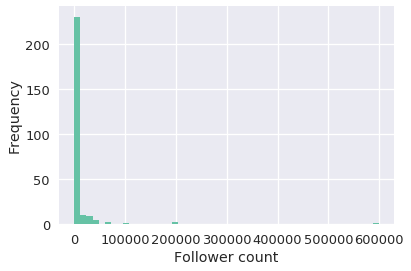

In [66]:
sns.distplot(df_count,kde=False,
            hist_kws = dict(alpha=1))

plt.xlabel("Follower count")
plt.ylabel("Frequency")
plt.show()

What's the CDF?

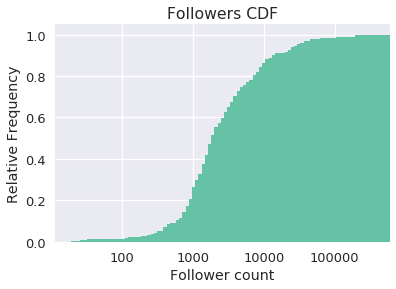

In [67]:
np.log10(df_count).hist(cumulative=True, bins=100, normed=True)
xticks = np.array([2,3,4,5])

xticklabels = 10**xticks

plt.title("Followers CDF")

plt.xticks(xticks,xticklabels)
plt.xlim(xmax=np.log10(df_count.values.max()))

plt.xlabel("Follower count")
plt.ylabel("Relative Frequency")

plt.show()

The distribution should make more in log scale:

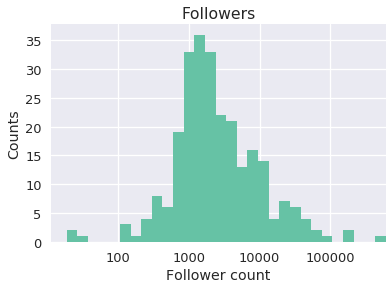

In [68]:
np.log10(df_count).hist(cumulative=False, bins=30, normed=False)
xticks = np.array([2,3,4,5])

xticklabels = 10**xticks

plt.title("Followers")

plt.xticks(xticks,xticklabels)
plt.xlim(xmax=np.log10(df_count.values.max()))

plt.xlabel("Follower count")
plt.ylabel("Counts")

plt.show()

From CDF we can see that more than 80% of the accounts have less than 10k followers
and about 20% less than 1000.

Looks like there are a few outliers. What is the distribution without them?
Let's exclude points two sigmas away from the mean.

In [69]:
insta_out = df_count > (df_count.mean() + 2*df_count.std())

In [70]:
# outliers
df_count[insta_out.values]

,Followers
Instagram,
cleenrockone,197520.0
blackink.125th,202020.0
inkbykyledunbar,106254.0
ryanhenrytattoo,598989.0


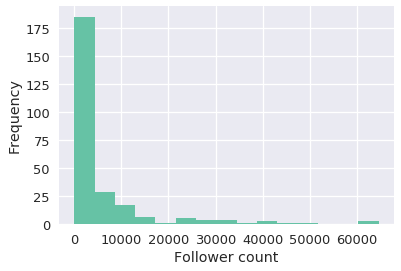

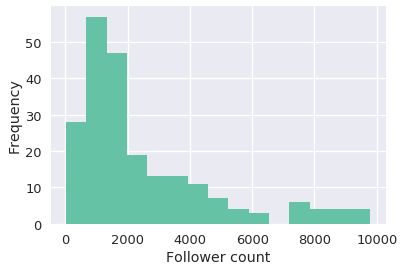

In [71]:
sns.distplot(df_count[~insta_out.values],
             kde=False, bins = 15,
            hist_kws = dict(alpha=1))

plt.xlabel("Follower count")
plt.ylabel("Frequency")
plt.show()


sns.distplot(df_count[(df_count < 1e4).values],
             kde=False, bins = 15,
            hist_kws = dict(alpha=1))

plt.xlabel("Follower count")
plt.ylabel("Frequency")
plt.show()

Top 10 instagram accounts:

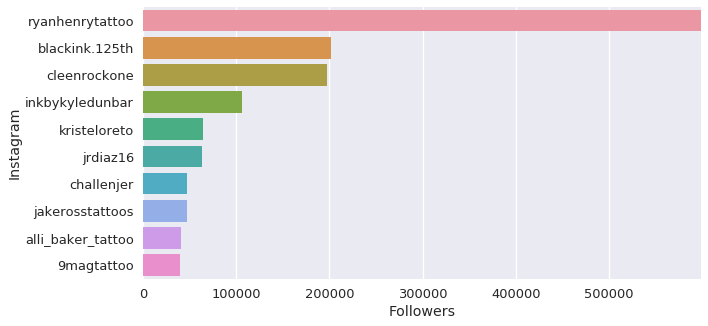

In [72]:
fig, ax = plt.subplots(figsize=(10,5))

top10 = data.sort_values('Followers', ascending=False)[0:10]

sns.barplot(x='Followers', y = 'Instagram', data = top10,
            ci=None, n_boot=0, ax = ax)
ax.set_xlim(xmax=top10.Followers.max())

plt.show()

Ok, let's now try to prepare a dataframe without studio instagram accounts.
There isn't a clear way to differentiate between an artist's and a studio's account.
However, we know that if an account is associated with more than one artist, then
it is a studio account, so we'll drop that like we did for df_count, but not keeping any of the duplicates copy.

In [102]:
df_profiles = data.drop_duplicates(subset='Instagram', keep=False)

Now what's left over should be seen by checking which artist's have more than one instagram.

In [103]:
df_profiles[df_profiles['Artist'].duplicated(keep=False)]

,Instagram,Followers,Artist
12,fishladdertattooco,1897.0,Alex Dell
13,alexdeltattoos,4115.0,Alex Dell
56,cameronbaxtertattoos,7591.0,Cam Baxter
57,GotInkClothing,14067.0,Cam Baxter
77,goldenskulltattoo,27915.0,Cleen Rock One
78,cleenrockone,197520.0,Cleen Rock One
85,trilogytattoogallery,10458.0,Danny Hernandez
86,dannynandez,4940.0,Danny Hernandez
118,blacksheepstudios,2045.0,Evin Barba
119,tattoosbyevinbarba,1289.0,Evin Barba


From here we can select manually which ones to drop:

In [104]:
acc_to_drop = [12, 57, 77, 85, 118, 121, 142, 164, 238, 266, 272, 283]

Curiously Tim Martin has two personal accounts, so we're keeping the one with the most followers.

In [106]:
df_profiles.drop(acc_to_drop, errors='ignore', inplace=True)

/home/modwyer/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's look at the distributions one more time:

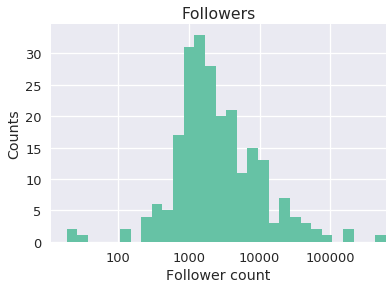

In [111]:
np.log10(df_profiles['Followers']).hist(cumulative=False, bins=30, normed=False)
xticks = np.array([2,3,4,5])

xticklabels = 10**xticks

plt.title("Followers")

plt.xticks(xticks,xticklabels)
plt.xlim(xmax=np.log10(df_profiles['Followers'].values.max()))

plt.xlabel("Follower count")
plt.ylabel("Counts")

plt.show()

In [213]:
def bar_label(ax):
    """Labels each bar in bar plot with number of instagram followers"""
    for p in ax.patches:
        label = str(int(np.round(p.get_width()/1000,decimals=0)))+'k'
        ax.text(x=ax.get_xlim()[-1]/200,
               y=p.get_y() + p.get_height()/1.4,
               s=label,
               fontdict=dict(weight='bold', color='white',size=12))

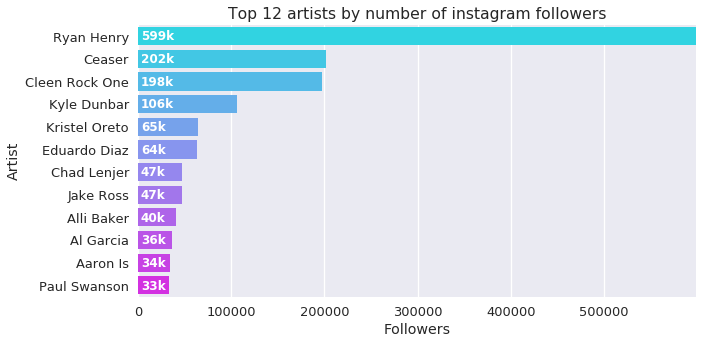

In [219]:
fig, ax = plt.subplots(figsize=(10,5))

n = 12
pal = sns.color_palette('cool',n)
top_artists = df_profiles.sort_values('Followers', ascending=False)[0:n]

sns.barplot(x='Followers', y = 'Artist', data = top_artists,
            ci=None, n_boot=0, ax = ax, palette=pal)
ax.set_xlim(xmax=top_artists.Followers.max())

bar_label(ax)

plt.title('Top {} artists by number of instagram followers'.format(n))
plt.show()